# Rice Leaf Disease Detection using FastAI

### Scraping image data from duckduckgo
for healthy rice leaves and different rice leaf diseases

In [ ]:
from duckduckgo_search import DDGS 
from fastcore.all import *

def search_images(keywords, max_images=200): return L(DDGS().images(keywords, max_results=max_images)).itemgot('image')
import time, json

In [2]:
urls = search_images('healthy rice leaf', max_images=1)
urls[0]

'https://www.healthbenefitstimes.com/9/gallery/african-rice/Leaves-of-African-rice.jpg'

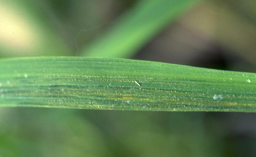

In [3]:
from fastdownload import download_url
dest = 'healthy_leaf.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

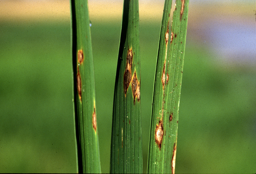

In [4]:
download_url(search_images('rice paddy leaf diseases', max_images=1)[0], 'paddy_disease.jpg', show_progress=False)
Image.open('paddy_disease.jpg').to_thumb(256,256)

In [5]:
searches = 'healthy rice leaf', 'rice bacterial leaf blight symptoms', 'rice blast disease leaf', 'rice brown spot disease', 'rice paddy leaf diseases'
path = Path('Rice')

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    time.sleep(5)
    resize_images(path/o, max_size=400, dest=path/o)

In [6]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

5

Only 5 image uploades failed, does not effect our training process much -> ignored

### We do a little Preprocessing

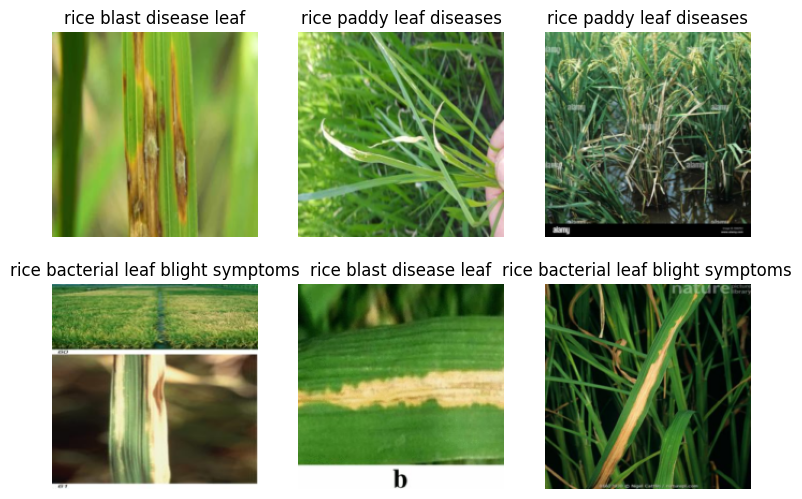

In [7]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

### Training using pre-tuned resnet

In [8]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(5)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\Shiven/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:14<00:00, 3.19MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,2.684951,2.055202,0.655172,00:14


epoch,train_loss,valid_loss,error_rate,time
0,1.743805,1.999703,0.682759,00:18
1,1.531154,2.299825,0.627586,00:19
2,1.262535,2.238141,0.613793,00:20
3,1.043606,2.302549,0.627586,00:37
4,0.897797,2.292130,0.606897,01:15


### Testing out the model

In [10]:
dest = 'brown.jpg'
download_url('https://www.agric.wa.gov.au/sites/gateway/files/leafblast.jpg', dest, show_progress=True)

Path('brown.jpg')

In [11]:
is_healthy,_,probs = learn.predict(PILImage.create('brown.jpg'))
print(f"This is a: {is_healthy}.")
# print(f"Probability it's a healthy leaf: {probs[0]:.4f}")
print(probs)

This is a: rice paddy leaf diseases.
tensor([0.0023, 0.0054, 0.4285, 0.0024, 0.5614])


Unwanted response but close to the actual answer. (rtx 3050 takes the L)

In [13]:
# learn.export('rice.pkl')

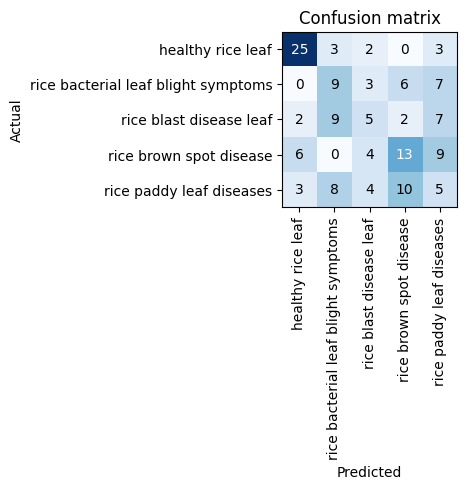

In [14]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

### Conclusion
This same notebook was used to train the classifier using same data and same no. of epochs but on Kaggle's P100 GPU which significantly outperformed the model trained on my local machine's GPU (rtx 3050). Exported model from kaggle will be used for final use.

Check out the kaggle notebook here: [Link](https://www.kaggle.com/code/shvn22k/rice-model/)